In [26]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
%load_ext tensorboard

hyperparam_tunning = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return mcc

def features_correlation(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals, _ = chi2(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()

In [36]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))

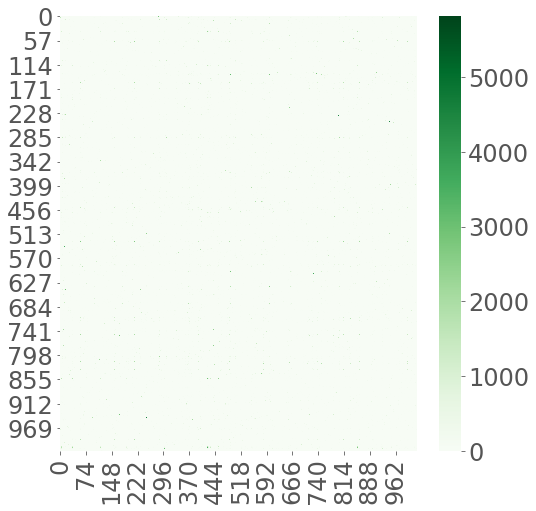

In [4]:
features_correlation(features_shared)

In [37]:
feat_select = SelectPercentile(chi2, percentile=10)
shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
only_2c9_reduced = feat_select.transform(features_only_2c9)
only_3a4_reduced = feat_select.transform(features_only_3a4)

threshold = 0.9
sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
features_shared = sel.fit_transform(features_shared)
features_only_2c9 = sel.transform(features_only_2c9)
features_only_3a4 = sel.transform(features_only_3a4)

combined_filters = VarianceThreshold(threshold=(threshold * (1 - threshold)))
shared_reduced_comb = combined_filters.fit_transform(shared_reduced)
only_2c9_reduced_comb = combined_filters.transform(only_2c9_reduced)
only_3a4_reduced_comb = combined_filters.transform(only_3a4_reduced)

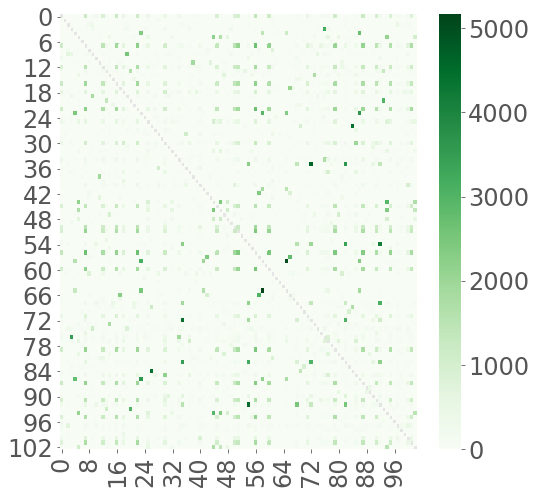

In [6]:
features_correlation(shared_reduced)

We will use the same train/test split with all tests

In [7]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9, random_state=42)

We try selecting the top features, moving the percentile value

In [8]:
hidden_layers = 4
neurons = 40
dropout = 0.2
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.Adam()
L2 = 0.010000
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 4 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 10 percentile, 7 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 15 percentile, 10 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 20 percentile, 14 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 25 percentile, 17 features
NER: 0.629, Sensitivity or recall: 0.305, Specificity: 0.952, Precision: 0.752, Correctly calssified: 0.744, MCC: 0.357
Testing
NER: 0.563, Sensitivity or recall: 0.205, Specificity: 0.920, Precision: 0.593, Correctly calssified: 0.662, MCC: 0.182
Validation set with 30 percentile, 20 features
NER: 0.685, Sensitivity or recall: 0.540, Specificity: 0.830, Precision: 0.601, Correctly calssified: 0.737, MCC: 0.382
Testing
NER: 0.604, Sensitivity or recall: 0.435, Specificity: 0.773, Precision: 0.520, Correctly calssified: 0.651, MCC: 0.218
Validation set with 35 percentile, 24 features
NER: 0.629, Sensitivity or recall: 0.317, Specificity: 0.941, Precision: 0.719, Correctly calssified: 0.741, MCC: 0.346
Tes

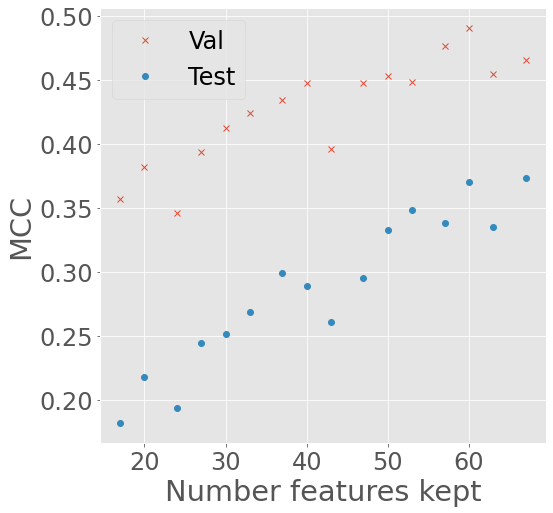

In [9]:
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 4 features
NER: 0.590, Sensitivity or recall: 0.248, Specificity: 0.932, Precision: 0.635, Correctly calssified: 0.713, MCC: 0.255
Testing
NER: 0.551, Sensitivity or recall: 0.184, Specificity: 0.918, Precision: 0.560, Correctly calssified: 0.653, MCC: 0.152
Validation set with 10 percentile, 7 features
NER: 0.597, Sensitivity or recall: 0.258, Specificity: 0.937, Precision: 0.659, Correctly calssified: 0.718, MCC: 0.274
Testing
NER: 0.538, Sensitivity or recall: 0.166, Specificity: 0.910, Precision: 0.512, Correctly calssified: 0.642, MCC: 0.115
Validation set with 15 percentile, 10 features
NER: 0.624, Sensitivity or recall: 0.342, Specificity: 0.907, Precision: 0.635, Correctly calssified: 0.725, MCC: 0.307
Testing
NER: 0.577, Sensitivity or recall: 0.299, Specificity: 0.855, Precision: 0.539, Correctly calssified: 0.654, MCC: 0.185
Validation set with 20 percentile, 14 features
NER: 0.659, Sensitivity or recall: 0.420, Specificity: 0.898, Precision

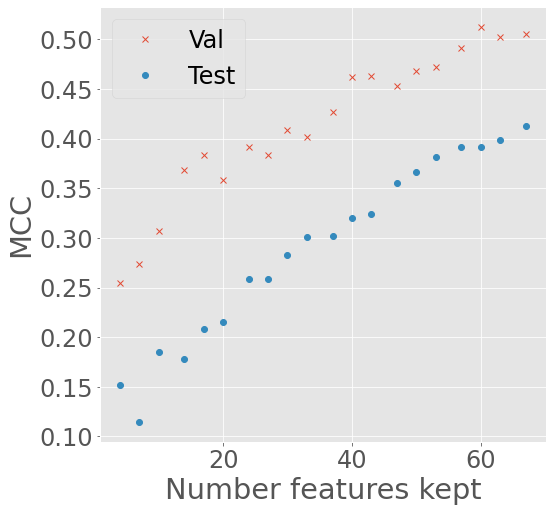

In [10]:
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = SVC(C=8, kernel="rbf")
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 4 features
Testing
Validation set with 10 percentile, 7 features
Testing
Validation set with 15 percentile, 10 features
Testing
Validation set with 20 percentile, 14 features
Testing
Validation set with 25 percentile, 17 features
Testing
Validation set with 30 percentile, 20 features
Testing
Validation set with 35 percentile, 24 features
Testing
Validation set with 40 percentile, 27 features
Testing
Validation set with 45 percentile, 30 features
Testing
Validation set with 50 percentile, 33 features
Testing
Validation set with 55 percentile, 37 features
Testing
Validation set with 60 percentile, 40 features
Testing
Validation set with 65 percentile, 43 features
Testing
Validation set with 70 percentile, 47 features
Testing
Validation set with 75 percentile, 50 features
Testing
Validation set with 80 percentile, 53 features
Testing
Validation set with 85 percentile, 57 features
Testing
Validation set with 90 percentile, 60 features
Testing
Validation se

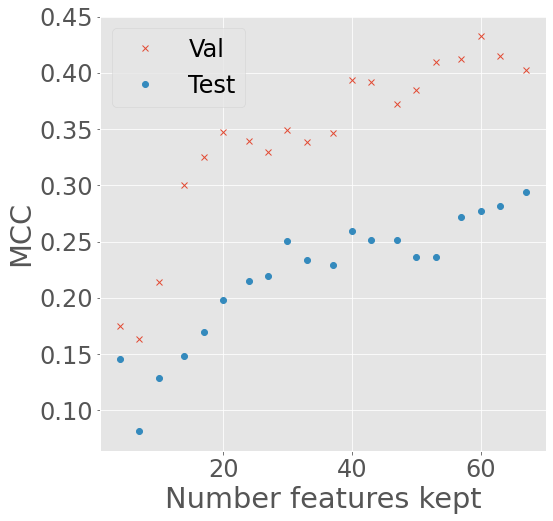

In [11]:
from sklearn.neighbors import KNeighborsClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = KNeighborsClassifier()
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 4 features
Testing
Validation set with 10 percentile, 7 features
Testing
Validation set with 15 percentile, 10 features
Testing
Validation set with 20 percentile, 14 features
Testing
Validation set with 25 percentile, 17 features
Testing
Validation set with 30 percentile, 20 features
Testing
Validation set with 35 percentile, 24 features
Testing
Validation set with 40 percentile, 27 features
Testing
Validation set with 45 percentile, 30 features
Testing
Validation set with 50 percentile, 33 features
Testing
Validation set with 55 percentile, 37 features
Testing
Validation set with 60 percentile, 40 features
Testing
Validation set with 65 percentile, 43 features
Testing
Validation set with 70 percentile, 47 features
Testing
Validation set with 75 percentile, 50 features
Testing
Validation set with 80 percentile, 53 features
Testing
Validation set with 85 percentile, 57 features
Testing
Validation set with 90 percentile, 60 features
Testing
Validation se

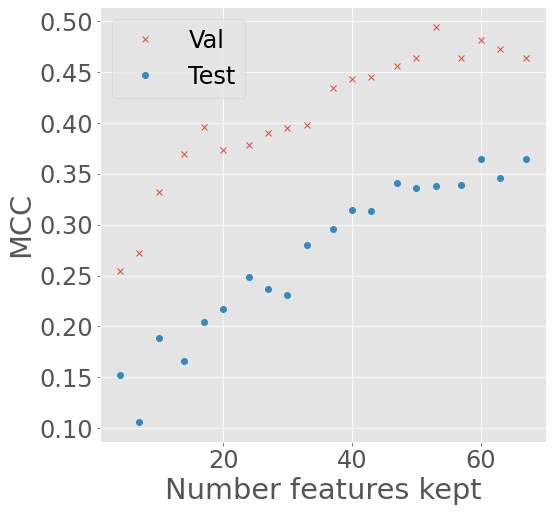

In [12]:
from sklearn.ensemble import RandomForestClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = RandomForestClassifier()
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Now we filter features according to variance, given that the input is binary, we use the variance formula for the Bernouilli probability distribution v=p*(1-p)

In [14]:
percentiles = [0.1*i for i in range(1, 10)]
MCCs = []
MCC_test = []
for percentile in percentiles:
    sel = VarianceThreshold(threshold=(percentile * (1 - percentile)))
    try:
        sel.fit(features_shared)
    except ValueError:
        MCCs.append(np.nan)
        MCC_test.append(np.nan)
        continue
    only_2c9_reduced_trans = sel.transform(features_only_2c9)
    train_data_trans = sel.transform(train_data)
    val_data_trans = sel.transform(val_data)
    N_BITS = train_data_trans.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 0.1 percentile, 67 features
NER: 0.723, Sensitivity or recall: 0.575, Specificity: 0.872, Precision: 0.680, Correctly calssified: 0.776, MCC: 0.469
Testing
NER: 0.666, Sensitivity or recall: 0.499, Specificity: 0.833, Precision: 0.628, Correctly calssified: 0.712, MCC: 0.353
Validation set with 0.2 percentile, 25 features
NER: 0.636, Sensitivity or recall: 0.347, Specificity: 0.925, Precision: 0.687, Correctly calssified: 0.739, MCC: 0.345
Testing
NER: 0.568, Sensitivity or recall: 0.238, Specificity: 0.899, Precision: 0.571, Correctly calssified: 0.660, MCC: 0.184
Validation set with 0.30000000000000004 percentile, 13 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.4 percentile, 5 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.6000000000000001 percentile, 5 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.7000000000000001 percentile, 13 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 0.8 percentile, 25 features
NER: 0.649, Sensitivity or recall: 0.388, Specificity: 0.909, Precision: 0.670, Correctly calssified: 0.742, MCC: 0.357
Testing
NER: 0.586, Sensitivity or recall: 0.287, Specificity: 0.885, Precision: 0.585, Correctly calssified: 0.669, MCC: 0.217
Validation set with 0.9 percentile, 67 features
NER: 0.707, Sensitivity or recall: 0.499, Specificity: 0.915, Precision: 0.735, Correctly calssified: 0.781, MCC: 0.468
Testing
NER: 0.646, Sensitivity or recall: 0.395, Specificity: 0.898, Precision: 0.687, Correctly calssified: 0.716, MCC: 0.347


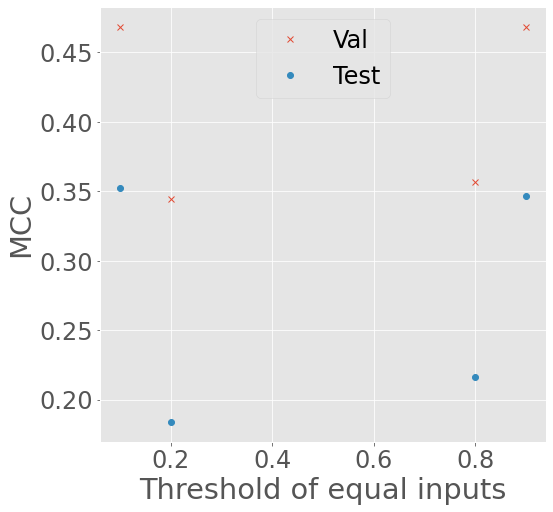

In [15]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Threshold of equal inputs")
plt.legend(loc="upper center")

We now combine the two feature selectors, setting the variance one at threshold 0.1

In [18]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    sel.fit(train_data_trans)
   
    train_data_trans = sel.transform(train_data_trans)
    val_data_trans = sel.transform(val_data_trans)
    only_2c9_reduced_trans = sel.transform(only_2c9_reduced_trans)
    N_BITS = train_data_trans.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 4 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 10 percentile, 7 features
NER: 0.605, Sensitivity or recall: 0.295, Specificity: 0.915, Precision: 0.621, Correctly calssified: 0.715, MCC: 0.272
Testing
NER: 0.546, Sensitivity or recall: 0.211, Specificity: 0.881, Precision: 0.500, Correctly calssified: 0.639, MCC: 0.122
Validation set with 15 percentile, 10 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 20 percentile, 13 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 25 percentile, 16 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 30 percentile, 19 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 35 percentile, 23 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 40 percentile, 26 features
NER: 0.687, Sensitivity or recall: 0.513, Specificity: 0.862, Precision: 0.637, Correctly calssified: 0.749, MCC: 0.399
Testing
NER: 0.613, Sensitivity or recall: 0.427, Specificity: 0.799, Precision: 0.545, Correctly calssified: 0.664, MCC: 0.241
Validation set with 45 percentile, 29 features


<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 50 percentile, 32 features
NER: 0.671, Sensitivity or recall: 0.440, Specificity: 0.901, Precision: 0.678, Correctly calssified: 0.753, MCC: 0.392
Testing
NER: 0.614, Sensitivity or recall: 0.351, Specificity: 0.877, Precision: 0.618, Correctly calssified: 0.687, MCC: 0.272
Validation set with 55 percentile, 36 features
NER: 0.698, Sensitivity or recall: 0.522, Specificity: 0.875, Precision: 0.664, Correctly calssified: 0.761, MCC: 0.426
Testing
NER: 0.636, Sensitivity or recall: 0.429, Specificity: 0.843, Precision: 0.606, Correctly calssified: 0.693, MCC: 0.299
Validation set with 60 percentile, 39 features
NER: 0.719, Sensitivity or recall: 0.598, Specificity: 0.840, Precision: 0.640, Correctly calssified: 0.763, MCC: 0.447
Tes

<ipython-input-2-33da3459ea09>:14: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-2-33da3459ea09>:17: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.679, MCC: nan
Testing
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly calssified: 0.639, MCC: nan
Validation set with 70 percentile, 46 features
NER: 0.705, Sensitivity or recall: 0.539, Specificity: 0.870, Precision: 0.663, Correctly calssified: 0.764, MCC: 0.435
Testing
NER: 0.636, Sensitivity or recall: 0.441, Specificity: 0.831, Precision: 0.596, Correctly calssified: 0.690, MCC: 0.295
Validation set with 75 percentile, 49 features
NER: 0.708, Sensitivity or recall: 0.527, Specificity: 0.889, Precision: 0.692, Correctly calssified: 0.772, MCC: 0.451
Testing
NER: 0.638, Sensitivity or recall: 0.426, Specificity: 0.850, Precision: 0.617, Correctly calssified: 0.697, MCC: 0.307
Validation set with 80 percentile, 52 features
NER: 0.710, Sensitivity or recall: 0.540, Specificity: 0.880, Precision: 0.681, Correctly calssified: 0.771, MCC: 0.450
Tes

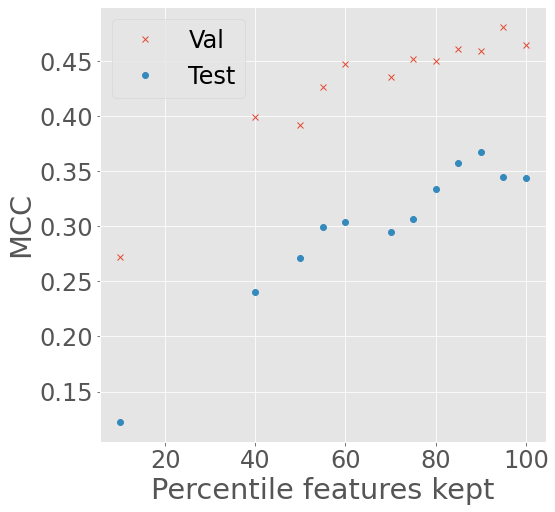

In [19]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

We repeat the same with a SVM model

Validation set with 5 percentile, 4 features
NER: 0.590, Sensitivity or recall: 0.248, Specificity: 0.932, Precision: 0.635, Correctly calssified: 0.713, MCC: 0.255
Testing
NER: 0.551, Sensitivity or recall: 0.184, Specificity: 0.918, Precision: 0.560, Correctly calssified: 0.653, MCC: 0.152
Validation set with 10 percentile, 7 features
NER: 0.597, Sensitivity or recall: 0.258, Specificity: 0.937, Precision: 0.659, Correctly calssified: 0.718, MCC: 0.274
Testing
NER: 0.538, Sensitivity or recall: 0.166, Specificity: 0.910, Precision: 0.512, Correctly calssified: 0.642, MCC: 0.115
Validation set with 15 percentile, 10 features
NER: 0.624, Sensitivity or recall: 0.342, Specificity: 0.907, Precision: 0.635, Correctly calssified: 0.725, MCC: 0.307
Testing
NER: 0.577, Sensitivity or recall: 0.299, Specificity: 0.855, Precision: 0.539, Correctly calssified: 0.654, MCC: 0.185
Validation set with 20 percentile, 13 features
NER: 0.652, Sensitivity or recall: 0.408, Specificity: 0.895, Precision

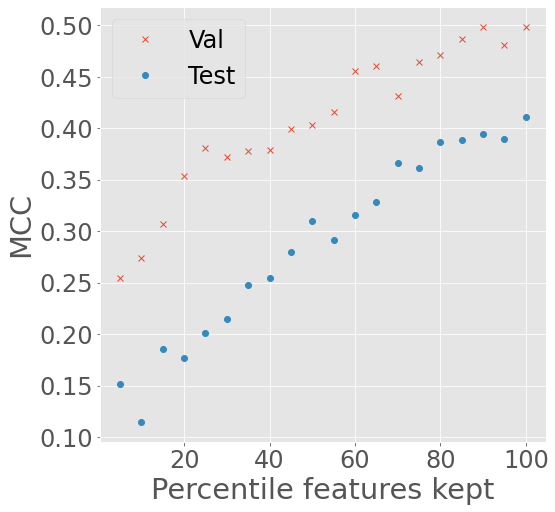

In [20]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    
    sel.fit(train_data_trans)
    train_data_trans = sel.transform(train_data_trans)
    val_data_trans = sel.transform(val_data_trans)
    only_2c9_reduced_trans = sel.transform(only_2c9_reduced_trans)
    N_BITS = train_data_trans.shape[1]
    svm = SVC(C=8, kernel="rbf")
    svm.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = svm.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = svm.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

In [38]:
print(features_shared.shape, features_only_2c9.shape, features_only_3a4.shape)
print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)

(9420, 67) (2813, 67) (2994, 67)
(9420, 103) (2813, 103) (2994, 103)
(9420, 30) (2813, 30) (2994, 30)


In [22]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [23]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(2, 6))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete(list(range(10, 61, 10))))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))

os.makedirs("hyperparameters_tunning/morgan_fingerprints_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy')])
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    model.fit(train_data, train_labels, epochs=10, verbose=2)
    _, results = model.evaluate(test_data, test_labels)
    return results

def run(run_dir, hparams):
      if os.path.exists(run_dir):
        return
      with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar("accuracy", accuracy, step=1)

In [27]:
if hyperparam_tunning:
    session_num = 0
    total_runs = len(HP_NEURONS.domain.values)*len(HP_HIDDEN_LAYERS.domain.values)*len([HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value])*len(HP_OPTIMIZER.domain.values)*len([HP_L2.domain.min_value, HP_L2.domain.max_value])*len(HP_LR.domain.values)
    looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

In [28]:
%tensorboard --logdir hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning

In [29]:
hidden_layers = 4
neurons = 40
dropout = 0.2
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.Adam()
L2 = 0.010000

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 4s 18ms/step - loss: 1.2550 - binary_accuracy: 0.6827
Epoch 2/10
221/221 [==============================] - 2s 7ms/step - loss: 0.6148 - binary_accuracy: 0.7439
Epoch 3/10
221/221 [==============================] - 3s 15ms/step - loss: 0.5505 - binary_accuracy: 0.7616
Epoch 4/10
221/221 [==============================] - 2s 11ms/step - loss: 0.5323 - binary_accuracy: 0.7699
Epoch 5/10
221/221 [==============================] - 2s 9ms/step - loss: 0.5170 - binary_accuracy: 0.7800
Epoch 6/10
221/221 [==============================] - 2s 10ms/step - loss: 0.5105 - binary_accuracy: 0.7803
Epoch 7/10
221/221 [==============================] - 2s 8ms/step - loss: 0.5027 - binary_accuracy: 0.7830
Epoch 8/10
221/221 [==============================] - 2s 11ms/step - loss: 0.4928 - binary_accuracy: 0.7849
Epoch 9/10
221/221 [==============================] - 4s 18ms/step - loss: 0.4892 - binary_accuracy: 0.7929
Epoch 10/10
221/221 [==========

Try the same NN with another feature selection method

In [30]:
# print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [39]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 4s 17ms/step - loss: 0.6701 - binary_accuracy: 0.7304
Epoch 2/10
221/221 [==============================] - 5s 21ms/step - loss: 0.5024 - binary_accuracy: 0.7812
Epoch 3/10
221/221 [==============================] - 5s 22ms/step - loss: 0.4865 - binary_accuracy: 0.7887
Epoch 4/10
221/221 [==============================] - 2s 10ms/step - loss: 0.4725 - binary_accuracy: 0.8031
Epoch 5/10
221/221 [==============================] - 1s 6ms/step - loss: 0.4672 - binary_accuracy: 0.8042
Epoch 6/10
221/221 [==============================] - 2s 7ms/step - loss: 0.4564 - binary_accuracy: 0.8127
Epoch 7/10
221/221 [==============================] - 1s 6ms/step - loss: 0.4531 - binary_accuracy: 0.8139
Epoch 8/10
221/221 [==============================] - 2s 7ms/step - loss: 0.4369 - binary_accuracy: 0.8309
Epoch 9/10
221/221 [==============================] - 1s 7ms/step - loss: 0.4310 - binary_accuracy: 0.8361
Epoch 10/10
221/221 [============

In [40]:
# print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced_comb, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [42]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced_comb)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 4s 18ms/step - loss: 0.7172 - binary_accuracy: 0.6900
Epoch 2/10
221/221 [==============================] - 5s 21ms/step - loss: 0.5712 - binary_accuracy: 0.7267
Epoch 3/10
221/221 [==============================] - 3s 14ms/step - loss: 0.5640 - binary_accuracy: 0.7329
Epoch 4/10
221/221 [==============================] - 3s 14ms/step - loss: 0.5546 - binary_accuracy: 0.7423
Epoch 5/10
221/221 [==============================] - 3s 14ms/step - loss: 0.5504 - binary_accuracy: 0.7425
Epoch 6/10
221/221 [==============================] - 3s 15ms/step - loss: 0.5483 - binary_accuracy: 0.7430
Epoch 7/10
221/221 [==============================] - 2s 8ms/step - loss: 0.5422 - binary_accuracy: 0.7464
Epoch 8/10
221/221 [==============================] - 1s 6ms/step - loss: 0.5401 - binary_accuracy: 0.7515
Epoch 9/10
221/221 [==============================] - 1s 6ms/step - loss: 0.5383 - binary_accuracy: 0.7516
Epoch 10/10
221/221 [==========

In [44]:
kernel = "rbf"
C_values = np.geomspace(0.1, 100, num=20)
for c in C_values:
    svm = SVC(C=c, kernel=kernel)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(val_data)
    print(f"Scores using C={c} for validation")
    print_metrics(predicted, val_labels)
    predictions = svm.predict(only_2c9_reduced_comb)
    print("  Scores for testing")
    print_metrics(predictions, labels_testing_2c9);

Scores using C=0.1 for validation
NER: 0.638, Sensitivity or recall: 0.329, Specificity: 0.946, Precision: 0.743, Correctly calssified: 0.748, MCC: 0.368
  Scores for testing
NER: 0.580, Sensitivity or recall: 0.231, Specificity: 0.928, Precision: 0.646, Correctly calssified: 0.677, MCC: 0.228
Scores using C=0.14384498882876628 for validation
NER: 0.650, Sensitivity or recall: 0.366, Specificity: 0.934, Precision: 0.725, Correctly calssified: 0.752, MCC: 0.380
  Scores for testing
NER: 0.587, Sensitivity or recall: 0.259, Specificity: 0.914, Precision: 0.631, Correctly calssified: 0.678, MCC: 0.234
Scores using C=0.20691380811147897 for validation
NER: 0.656, Sensitivity or recall: 0.380, Specificity: 0.932, Precision: 0.727, Correctly calssified: 0.755, MCC: 0.391
  Scores for testing
NER: 0.593, Sensitivity or recall: 0.281, Specificity: 0.905, Precision: 0.626, Correctly calssified: 0.680, MCC: 0.243
Scores using C=0.29763514416313175 for validation
NER: 0.663, Sensitivity or recall